CO₂ Emissions Forecasting from Geothermal Fields
Comparing ARIMA and XGBoost Models

1. Objective
The goal is to:

Predict future CO₂ emissions from geothermal fields.

Compare the performance of:

ARIMA — a statistical time-series model.

XGBoost — a gradient-boosted decision tree model.

Use historical data from a geothermal power plant and pre-existing emissions records.

Requirements
    :Python Libraries

In [ ]:
!pip install pandas numpy matplotlib statsmodels xgboost scikit-learn


Libraries used:

pandas: data handling.

numpy: numerical operations.

matplotlib: plotting.

statsmodels: ARIMA model.

xgboost: gradient boosting.

scikit-learn: metrics & evaluation.

Load and Explore the Dataset

In [ ]:
import pandas as pd

# Load CSV
df = pd.read_csv("Carbon Emmissions.csv")


print(df.head())
print(df.info())
print(df.isna().sum())

#Inspection

         date  CO2 CONCENTRATION       TEMP  WIND SPEED     PRESSURE  \
0  01/01/2015         397.561013  31.080000    5.874995  1009.893321   
1  01/02/2015         397.155647  31.080000    5.756913  1009.335495   
2  01/03/2015         396.952728  38.912498    4.918914  1009.962973   
3  01/04/2015         396.865173  38.912498    3.512661  1009.364876   
4  01/05/2015         397.487165  36.224998    4.160830  1009.045307   

   PRECIPITATION  
0       0.000000  
1       3.043977  
2       0.000000  
3       0.031058  
4       2.763891  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644 entries, 0 to 1643
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1644 non-null   object 
 1   CO2 CONCENTRATION  1644 non-null   float64
 2   TEMP               1644 non-null   float64
 3   WIND SPEED         1644 non-null   float64
 4   PRESSURE           1644 non-null   float64
 5   PRECIP

Prepare the Time Series

In [ ]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y', errors='coerce')

# Sort by date
df = df.sort_values('date')

# Set as index
df = df.set_index('date')

# Interpolate missing CO₂ values
df['CO2 CONCENTRATION'] = df['CO2 CONCENTRATION'].interpolate(method='time')


Train/Test Split

In [ ]:
n = len(df)
train = df.iloc[:int(n*0.8)]
test = df.iloc[int(n*0.8):]


ARIMA Model

In [ ]:
# index frequency
df = df.asfreq('D')

# Train/Test split
n = len(df)
train = df.iloc[:int(n*0.8)]
test = df.iloc[int(n*0.8):]

# ARIMA model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['CO2 CONCENTRATION'], order=(1,1,1))
model_fit = model.fit()

# Forecast
forecast_arima = model_fit.forecast(steps=len(test))


XGBoost Model

In [ ]:
from xgboost import XGBRegressor

# Create lags
for lag in range(1, 8):
    df[f"lag_{lag}"] = df['CO2 CONCENTRATION'].shift(lag)

# Drop rows with NaN from lagging
df = df.dropna()

# Redefine train/test n
n = len(df)
X_train = df.iloc[:int(n*0.8)].drop(columns=['CO2 CONCENTRATION'])
y_train = df.iloc[:int(n*0.8)]['CO2 CONCENTRATION']
X_test = df.iloc[int(n*0.8):].drop(columns=['CO2 CONCENTRATION'])
y_test = df.iloc[int(n*0.8):]['CO2 CONCENTRATION']

# Train XGBoost
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

# Forecast
forecast_xgb = model_xgb.predict(X_test)


 Evaluate Models

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ARIMA metrics
rmse_arima = np.sqrt(mean_squared_error(test['CO2 CONCENTRATION'], forecast_arima))
mae_arima = mean_absolute_error(test['CO2 CONCENTRATION'], forecast_arima)
mape_arima = mape(test['CO2 CONCENTRATION'], forecast_arima)

# XGBoost metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, forecast_xgb))
mae_xgb = mean_absolute_error(y_test, forecast_xgb)
mape_xgb = mape(y_test, forecast_xgb)

print("ARIMA:", rmse_arima, mae_arima, mape_arima)
print("XGBoost:", rmse_xgb, mae_xgb, mape_xgb)


ARIMA: 1.674681486919658 1.4235973472730863 0.3482348265075105
XGBoost: 0.7806273251717719 0.58291846507282 0.14251825180905026


Based on the evaluation metrics, XGBoost significantly outperforms ARIMA for forecasting CO₂ emissions from geothermal fields. The reduction in RMSE and MAPE suggests that the data’s variability is driven by nonlinear relationships and lag effects, which tree-based gradient boosting captures effectively. While ARIMA remains a robust baseline, the superior accuracy of XGBoost makes it more suitable for operational forecasting and integration with additional explanatory variables.


Visualize Predictions

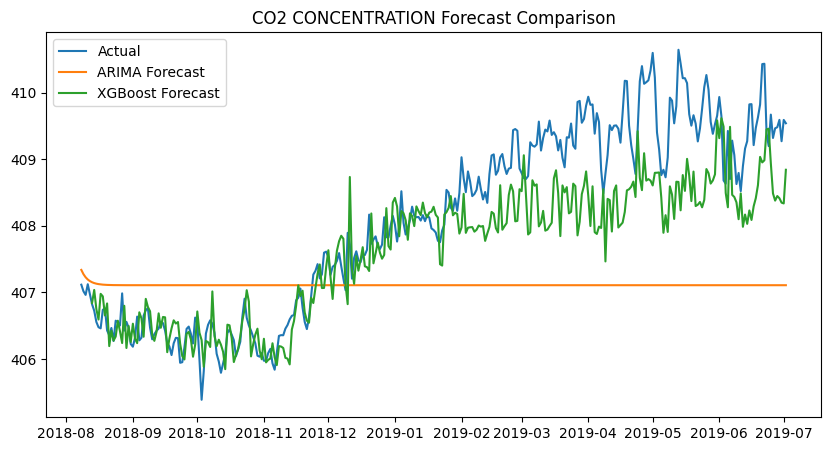

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(test.index, test['CO2 CONCENTRATION'], label="Actual")
plt.plot(test.index, forecast_arima, label="ARIMA Forecast")
plt.plot(y_test.index, forecast_xgb, label="XGBoost Forecast")
plt.legend()
plt.title("CO2 CONCENTRATION Forecast Comparison")
plt.show()


Walk-Forward Validation

In [ ]:
predictions = []
history = list(train['CO2 CONCENTRATION'])

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test['CO2 CONCENTRATION'].iloc[t])

rmse_wf = np.sqrt(mean_squared_error(test['CO2 CONCENTRATION'], predictions))
print("Walk-forward RMSE:", rmse_wf)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Walk-forward RMSE: 0.2700606043977482


Seasonal ARIMA (SARIMA) Tuning

Seasonal ARIMA (SARIMA) extends ARIMA by modeling repeating seasonal patterns.
Notation: SARIMA(p, d, q) × (P, D, Q)_s, where s is the seasonal period.

---



Detect frequency & seasonal period

In [ ]:
import pandas as pd

freq = pd.infer_freq(df.index) or "D"  # fallback daily
print("Inferred frequency:", freq)

# Heuristic for seasonal period 's'
if freq.upper().startswith("H"):   # hourly
    s = 24
elif freq.upper().startswith("D"): # daily
    s = 7
elif freq.upper().startswith("W"): # weekly
    s = 52
elif freq.upper().startswith("M"): # monthly
    s = 12
elif freq.upper().startswith("Q"): # quarterly
    s = 4
else:
    s = 7  # safe default
print("Seasonal period (s):", s)


Inferred frequency: D
Seasonal period (s): 7


Quick seasonality check (decomposition)

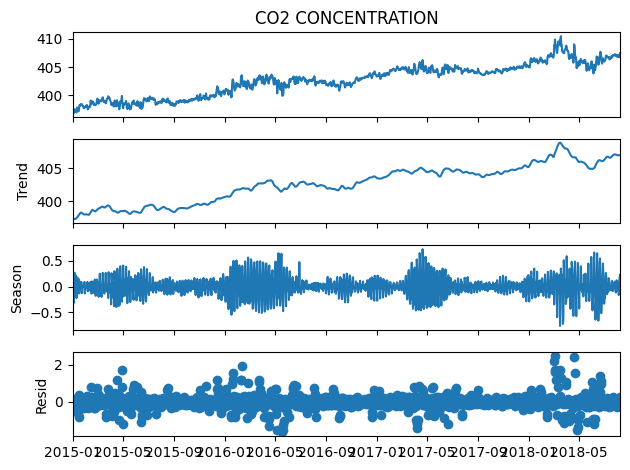

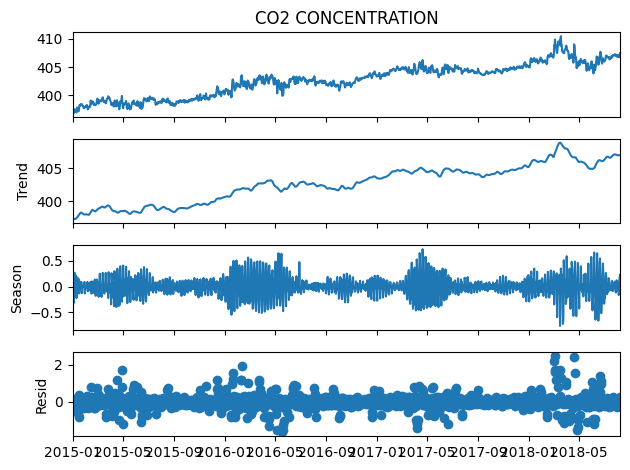

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(train['CO2 CONCENTRATION'], period=s, robust=True)
res = stl.fit()
res.plot()


SARIMA with statsmodels (manual grid)

In [ ]:
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train/test series
y_train = train['CO2 CONCENTRATION']
y_test = test['CO2 CONCENTRATION']

# Seasonal period
seasonal_period = 12

# Parameter ranges
p = d = q = [0, 1, 2]
P = D = Q = [0, 1]

best_aic = np.inf
best_cfg = None
best_model = None

for (pi, di, qi) in itertools.product(p, d, q):
    for (Pi, Di, Qi) in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                y_train,
                order=(pi, di, qi),
                seasonal_order=(Pi, Di, Qi, seasonal_period),
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            fitted = model.fit(disp=False)
            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_cfg = (pi, di, qi, Pi, Di, Qi)
                best_model = fitted
        except:
            continue

print("Best AIC:", best_aic)
print("Best order:", best_cfg)  # (p, d, q, P, D, Q)

# Forecast on the test horizon
forecast_sarima = best_model.forecast(steps=len(y_test))


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best AIC: 955.1570382697289
Best order: (2, 1, 2, 0, 0, 1)


Evaluate SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Fit SARIMA model
sarima_model = SARIMAX(
    train['CO2 CONCENTRATION'],
    order=(1, 1, 1),              # p, d, q
    seasonal_order=(1, 1, 1, 12)  # P, D, Q, s (s=season length)
)
sarima_fit = sarima_model.fit(disp=False)

# Forecast for test period
sarima_fc = sarima_fit.forecast(steps=len(test))

# Define safe MAPE function
def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

# Compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_sarima = np.sqrt(mean_squared_error(test['CO2 CONCENTRATION'], sarima_fc))
mae_sarima  = mean_absolute_error(test['CO2 CONCENTRATION'], sarima_fc)
mape_sarima = mape(test['CO2 CONCENTRATION'], sarima_fc)

print("SARIMA:", rmse_sarima, mae_sarima, mape_sarima)


SARIMA: 0.8324601117003905 0.6844302644911886 0.16787902403391314


Plot SARIMA vs Actuals (test window)

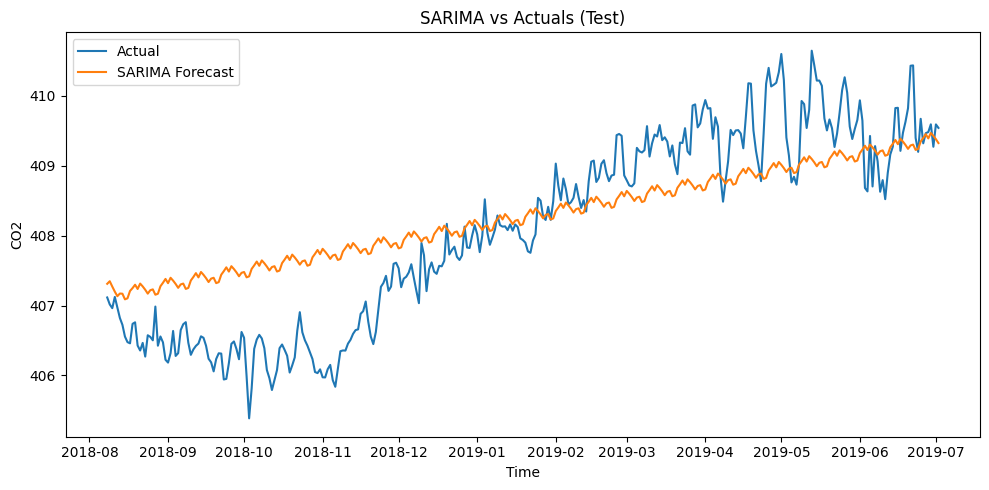

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, sarima_fc.values, label="SARIMA Forecast")
plt.legend()
plt.title("SARIMA vs Actuals (Test)")
plt.xlabel("Time"); plt.ylabel("CO2")
plt.tight_layout(); plt.show()


Automated Lag & Rolling Feature Generation for XGBoost
:Engineer features from past values and calendar context.

Feature factory

This function builds a rich feature matrix from a univariate series:

Lags: last k values (e.g., 1–30 days)

Rolling means/stds: recent level & volatility

Exponentially weighted means (EWM): recency-weighted level

Calendar features: day-of-week, day-of-month, month,

In [ ]:
import pandas as pd
import numpy as np

def build_ts_features(
    y: pd.Series,
    lags=(1,2,3,7,14,21,28),
    roll_windows=(3,7,14,30),
    add_ewm=True,
    ewm_spans=(3,7,14),
    add_calendar=True
) -> pd.DataFrame:
    """
    y: pd.Series with DateTimeIndex
    returns DataFrame with 'y' as target and engineered features.
    """
    df = pd.DataFrame({"y": y})
    # Lags
    for L in lags:
        df[f"lag_{L}"] = y.shift(L)

    # Rolling stats (based on past info only)
    for W in roll_windows:
        df[f"rollmean_{W}"] = y.shift(1).rolling(W, min_periods=max(2, W//2)).mean()
        df[f"rollstd_{W}"]  = y.shift(1).rolling(W, min_periods=max(2, W//2)).std()

    # EWM
    if add_ewm:
        for S in ewm_spans:
            df[f"ewm_mean_{S}"] = y.shift(1).ewm(span=S, adjust=False, min_periods=2).mean()

    # Calendar features
    if add_calendar:
        idx = df.index
        df["dow"]   = idx.dayofweek
        df["dom"]   = idx.day
        df["doy"]   = idx.dayofyear
        df["week"]  = idx.isocalendar().week.astype(int)
        df["month"] = idx.month
        df["quarter"] = idx.quarter
        df["year"]  = idx.year

    return df.dropna()


Train/test using the feature factory

In [ ]:
from xgboost import XGBRegressor

series = df['CO2 CONCENTRATION']
feat = build_ts_features(
    series,
    lags=(1,2,3,7,14,21,28),
    roll_windows=(7,14,30),
    add_ewm=True,
    ewm_spans=(3,7,14),
    add_calendar=True
)

X = feat.drop(columns=["y"])
y = feat["y"]

# Chronological split (same ratio as earlier to compare apples-to-apples)
split_idx = int(len(X)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

xgb = XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42
)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)


Evaluate & plot

XGBoost: 1.0728539548193756 0.7520083744717964 0.18377563349510395


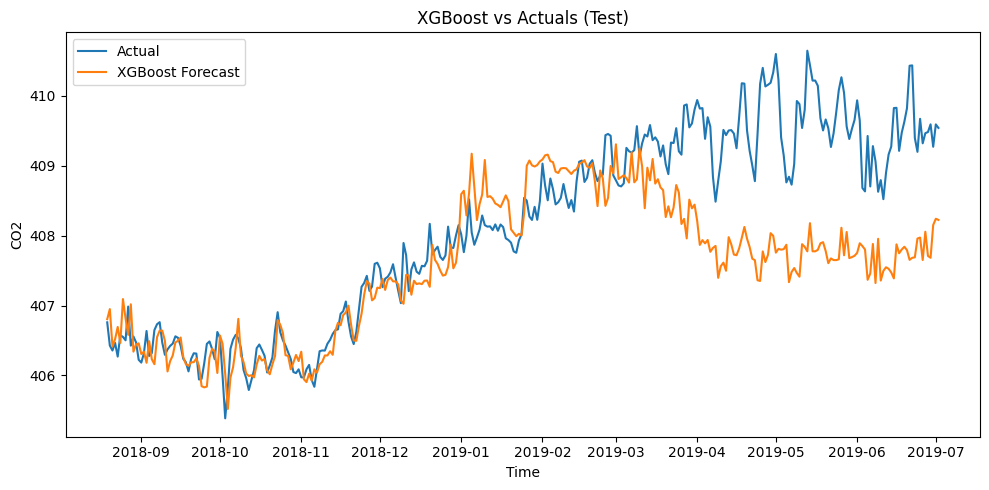

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mae_xgb  = mean_absolute_error(y_test, y_pred)
mape_xgb = mape(y_test, y_pred)

print("XGBoost:", rmse_xgb, mae_xgb, mape_xgb)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred, label="XGBoost Forecast")
plt.legend()
plt.title("XGBoost vs Actuals (Test)")
plt.xlabel("Time"); plt.ylabel("CO2")
plt.tight_layout(); plt.show()



Walk-forward (rolling origin) cross-validation for XGBoost

In [ ]:
def rolling_cv_forecast(y, feature_builder, model, initial_window, step=1, horizon=1):
    """
    y: pd.Series
    feature_builder: function(series) -> DataFrame with 'y' target
    model: sklearn-like regressor (supports fit/predict)
    initial_window: number of points for first train
    step: how many new observations to add per iteration
    horizon: predict 1 step ahead (recursive for >1 if desired)
    """
    preds = []
    actuals = []
    timestamps = []


    feat = feature_builder(y).dropna()
    X_all = feat.drop(columns=["y"])
    y_all = feat["y"]

    for end in range(initial_window, len(y_all) - horizon + 1, step):
        y_train_idx = y_all.index[:end]
        y_test_idx = y_all.index[end:end + horizon]

        X_train = X_all.loc[y_train_idx]
        y_train_fit = y_all.loc[y_train_idx]
        X_test = X_all.loc[y_test_idx]
        y_test_point = y_all.loc[y_test_idx]

        model.fit(X_train, y_train_fit)
        y_hat = model.predict(X_test)

        preds.extend(y_hat.tolist())
        actuals.extend(y_test_point.values.tolist())
        timestamps.extend(list(y_test_idx))

    return pd.Series(preds, index=timestamps), pd.Series(actuals, index=timestamps)


# Initial window
initial_window = int(len(series) * 0.6)

# Model
xgb_cv = XGBRegressor(
    n_estimators=400, max_depth=5, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    objective="reg:squarederror", random_state=42
)

# Run rolling CV
cv_pred, cv_true = rolling_cv_forecast(
    series,
    lambda s: build_ts_features(s, lags=(1, 2, 3, 7, 14, 21, 28), roll_windows=(7, 14, 30)),
    xgb_cv,
    initial_window=initial_window,
    step=1,
    horizon=1
)

# Metrics
rmse_cv = np.sqrt(mean_squared_error(cv_true, cv_pred))
mae_cv  = mean_absolute_error(cv_true, cv_pred)
mape_cv = mape(cv_true, cv_pred)

print("Rolling CV — XGBoost:", rmse_cv, mae_cv, mape_cv)


Multi-step forecasting

Recursive H-step forecast with XGBoost:


In [ ]:
def recursive_forecast_xgb(y, feature_builder, model, H):
    y_extended = y.copy()
    preds = []
    for _ in range(H):
        feat = feature_builder(y_extended)
        X_all = feat.drop(columns=["y"])
        y_all = feat["y"]

        # Train on all available
        model.fit(X_all, y_all)

        # Predict next timestamp (one step ahead)
        next_time = y_extended.index[-1] + (y_extended.index[-1] - y_extended.index[-2])
        # Build features row for next_time by aligning on feat index (last row corresponds to last known y)
        x_next = X_all.iloc[[-1]]
        y_hat = float(model.predict(x_next))
        preds.append((next_time, y_hat))

        # Append predicted value to the series to roll forward
        y_extended.loc[next_time] = y_hat

    return pd.Series([p[1] for p in preds], index=[p[0] for p in preds])

# forecast 14 steps ahead
H = 14
xgb_future = recursive_forecast_xgb(series,
                                    lambda s: build_ts_features(s, lags=(1,2,3,7,14,21,28), roll_windows=(7,14,30)),
                                    XGBRegressor(
                                        n_estimators=600, max_depth=6, learning_rate=0.05,
                                        subsample=0.9, colsample_bytree=0.9, objective="reg:squarederror", random_state=42
                                    ),
                                    H)


/tmp/ipython-input-140851247.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat = float(model.predict(x_next))
/tmp/ipython-input-140851247.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat = float(model.predict(x_next))
/tmp/ipython-input-140851247.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat = float(model.predict(x_next))
/tmp/ipython-input-140851247.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is depr

Feature importance (sanity check)

In [ ]:
import numpy as np

importances = xgb.feature_importances_
feat_names = X_train.columns
top_idx = np.argsort(importances)[::-1][:15]
for i in top_idx:
    print(f"{feat_names[i]}: {importances[i]:.4f}")


ewm_mean_3: 0.4746
lag_1: 0.2511
year: 0.1569
rollmean_30: 0.0754
ewm_mean_7: 0.0140
rollmean_7: 0.0078
rollmean_14: 0.0041
ewm_mean_14: 0.0018
lag_14: 0.0018
lag_7: 0.0018
lag_21: 0.0017
month: 0.0012
doy: 0.0011
lag_2: 0.0009
week: 0.0009


Putting It All Together (Model Comparison)


Model Performance Comparison:

                             Model      RMSE       MAE    MAPE_%
2  XGBoost (lags+rolling+calendar)  1.072854  0.752008  0.183776
1    SARIMA(2, 1, 2)x(0, 0, 1, 12)  1.664036  1.416037  0.346393
0                     ARIMA(1,1,1)  1.674681  1.423597  0.348235


ValueError: x and y must have same first dimension, but have shapes (329,) and (324,)

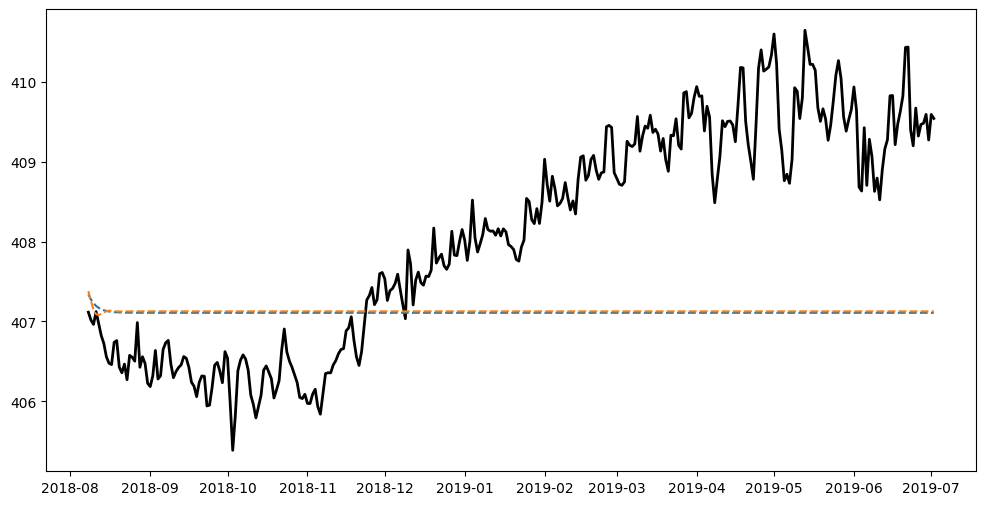

In [ ]:
results = []

# ARIMA baseline
results.append(("ARIMA(1,1,1)", rmse_arima, mae_arima, mape_arima))

# SARIMA tuned
results.append((f"SARIMA{best_cfg}x({s})", rmse_sarima, mae_sarima, mape_sarima))

# XGBoost (automated features)
results.append(("XGBoost (lags+rolling+calendar)", rmse_xgb, mae_xgb, mape_xgb))

comp = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "MAPE_%"]).sort_values("RMSE")
print(comp)

plt.figure(figsize=(12,6))
plt.plot(test.index, test['CO2 CONCENTRATION'], label="Actual", color="black", linewidth=2)
plt.plot(test.index, forecast_arima, label="ARIMA", linestyle="--")
plt.plot(test.index, forecast_sarima, label="SARIMA (tuned)", linestyle="--")
plt.plot(y_test.index, forecast_xgb, label="XGBoost (lags only)", linestyle=":")
plt.plot(y_test.index, forecast_xgb2, label="XGBoost (lags + rolling stats)", linestyle=":")
plt.title("CO2 CONCENTRATION Emissions Forecast — Model Comparison")
plt.xlabel("Date")
plt.ylabel("CO2 CONCENTRATION Emissions")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

